In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import math
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/DPA_24.2_OnePoseTxTyR_v1.0.2.5")

In [70]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [71]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####
degree = 180 / math.pi
radian = math.pi / 180

# https://math.stackexchange.com/questions/13150/extracting-rotation-scale-values-from-2d-transformation-matrix/13165#13165
def TransformDecomposition(transform):
    a = transform[0,0]
    b = transform[0,1]
    c = transform[1,0]
    d = transform[1,1]

    tx = transform[0,2]
    ty = transform[1,2]
    delta = a * d - b * c

    if (a != 0 or b != 0):
        r = math.sqrt(a * a + b * b)
        rotation = math.acos(a / r) if b > 0 else -math.acos(a / r)
        scaleX, scaleY = r, delta / r
        # skew = (math.atan((a * c + b * d) / (r * r)), 0)
    elif (c != 0 or d != 0):
        s = math.sqrt(c * c + d * d)
        rotation = math.PI / 2 - (math.acos(-c / s) if d > 0 else -math.acos(c / s))
        scaleX, scaleY = delta / s, s
        # skew = (0, math.atan((a * c + b * d) / (s * s)))
    else:
        a = b = c = d = 0

    rotationInDegree = rotation * degree
    return tx, ty, scaleX, scaleY, rotationInDegree

class data(Dataset):
    def __init__(self, path):
        self.path = path
        self.Items = []

        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)

        self.files = os.listdir(path)

        for ML_Record in self.files:
            DatasetItem = json.load(open(os.path.join(self.path, ML_Record)))
            for i in range(0, 200):

                src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
                dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)
                originalTransfrom = np.matrix(DatasetItem["transformation"])

                translationX = random.uniform(80, 150) * random.choice([1, -1])
                translationY = random.uniform(80, 120) * random.choice([1, -1])
                scale = random.uniform(0.8, 1.2)
                rotation = random.uniform(5, 15) * random.choice([1, -1])

                AugmentingMat = np.mat([[scale, 0., translationX], [0., scale, translationY], [0., 0., 1.]] , dtype=np.float32)
                rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), rotation, 1)
                AugmentingMat = np.matmul(np.vstack([rotationMat, [0,0,1]]), AugmentingMat, dtype=np.float32)

                invertedAugmentingMat = np.mat(cv2.invertAffineTransform(AugmentingMat[0:-1, : ]))
                invertedAugmentingMat = np.vstack([invertedAugmentingMat, [0,0,1]])

                GeneratedTransform = np.matmul(originalTransfrom, invertedAugmentingMat)
                GT_Tx, GT_Ty, GT_s, _, GT_Rotation = TransformDecomposition(GeneratedTransform)
                GT = torch.from_numpy(np.array([GT_Tx, GT_Ty, GT_s, GT_Rotation], dtype=np.float32))

                warped = cv2.warpAffine(src, AugmentingMat[0:-1, : ], (1440, 1440))

                warped = cv2.resize(warped, (128, 128))
                dst = cv2.resize(dst, (128, 128))

                stacked = torch.stack((convert_tensor(dst), convert_tensor(warped)))
                paths = {
                    "src" : DatasetItem["src"],
                    "dst" : DatasetItem["dst"]
                }
                self.Items.append( (stacked, GT, paths ))

    # the function returns length of data
    def __len__(self):
        return len(self.Items)

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [72]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(16384, 1024)

        self.fc10 = nn.Linear(1024, 4)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
            
        return x

    def forward(self, x):

        x = self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
        
        return x


In [73]:
#### Create data ####
def weighted_mse_loss(input, target, weights = torch.FloatTensor([1, 1, 1500, 50]).to(device)):
        return (weights * (input - target) ** 2).mean()

batchSize = 25

Dataset = data('.\\..\\data03\MachineData')
train_set, val_set = torch.utils.data.random_split(Dataset, [int(Dataset.__len__() * 0.8), Dataset.__len__() - int(Dataset.__len__() * 0.8)])
train_dataloader = DataLoader(train_set, batch_size=batchSize, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net().to(device)
loss_function = weighted_mse_loss
# loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0)

example_images, example_groundTruths, _ = iter(train_dataloader).next()
writer.add_graph(net, example_images.to(device).view(-1, 2, 128, 128))

Epochs = 24
train_set_len = len(train_set)  
# Learning
for epoch in range(Epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    batchCount = 0
    for i, dataBatch in enumerate(train_dataloader):
        Images, groundTruths, _ = dataBatch
        Images, groundTruths = Images.to(device), groundTruths.to(device)

        optimizer.zero_grad()

        outputs = net(Images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,4))
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        epoch_loss += loss.item()
        batchCount += 1

        if((i+1)%2 == 0):
            writer.add_scalar('training loss', running_loss / 2, (train_set_len * epoch) + (i * batchSize) )
            running_loss = 0.0

    # Training
    print(f"Epoch: {epoch}. Loss: {epoch_loss / batchCount}")

Epoch: 0. Loss: 64634.36683238636
Epoch: 1. Loss: 34667.09626116072
Epoch: 2. Loss: 30015.550223214286
Epoch: 3. Loss: 21022.57003348214
Epoch: 4. Loss: 15758.559265929383
Epoch: 5. Loss: 10013.759049056413
Epoch: 6. Loss: 6988.278025441356
Epoch: 7. Loss: 3954.4807097199673
Epoch: 8. Loss: 2595.5163162033277
Epoch: 9. Loss: 1683.7571316013089
Epoch: 10. Loss: 1429.5320965655437
Epoch: 11. Loss: 1012.6349511084619
Epoch: 12. Loss: 1067.8479447798295
Epoch: 13. Loss: 691.8396630225244
Epoch: 14. Loss: 544.5821410340149
Epoch: 15. Loss: 437.4499694031554
Epoch: 16. Loss: 477.25955338911575
Epoch: 17. Loss: 761.7609094396814
Epoch: 18. Loss: 607.6671126724838
Epoch: 19. Loss: 408.57196540337105
Epoch: 20. Loss: 294.7145902955687
Epoch: 21. Loss: 259.0433159369927
Epoch: 22. Loss: 299.0474140117695
Epoch: 23. Loss: 226.56530543736048
Epoch: 24. Loss: 246.21561867850167
Epoch: 25. Loss: 243.7892349044998
Epoch: 26. Loss: 280.64621288745434
Epoch: 27. Loss: 557.3378026392553
Epoch: 28. Loss:

In [74]:
iterations = []
imageCounter = 0
with torch.no_grad():
        for dataBatch in val_dataloader:
                Images, groundTruths, paths = dataBatch
                Images, groundTruths = Images.to(device), groundTruths.to(device)
                outputs = net(Images.view(-1, 2, 128, 128)) 

                # writing on disk for demo
                # srcPath = paths["src"][0]
                # dstPath = paths["dst"][0]
                # src = cv2.imread(srcPath, cv2.IMREAD_ANYCOLOR)
                # dst = cv2.imread(dstPath, cv2.IMREAD_ANYCOLOR)    

                src = Images[0][1]
                src = src.cpu().detach().numpy()
                src = cv2.resize(src[0], (1440, 1440))

                output = np.array(outputs[0].cpu()) 
                translationMat = np.mat([[output[2], 0., output[0]], [0., output[2], output[1]], [0., 0., 1.]] , dtype=np.float32)
                rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), output[3], 1)
                outputTransform = np.matmul(np.vstack([rotationMat, [0,0,1]]), translationMat, dtype=np.float32)

                warped = cv2.warpAffine(src, outputTransform[0:-1, : ], (src.shape[1], src.shape[0]))

                grayImage = np.array(warped * 255, dtype = np.uint8)
                cv2.imwrite(f".\\..\\CNNAlignedImages\\Image{imageCounter}.png", grayImage)
                imageCounter += 1

                loss = loss_function(outputs, groundTruths.view(-1,4))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

Ground Truth :
 [479.962 462.972   0.863   8.268]
Transofrm    :
 [471.198 454.779   1.049   8.253]
loss: 48.86061477661133


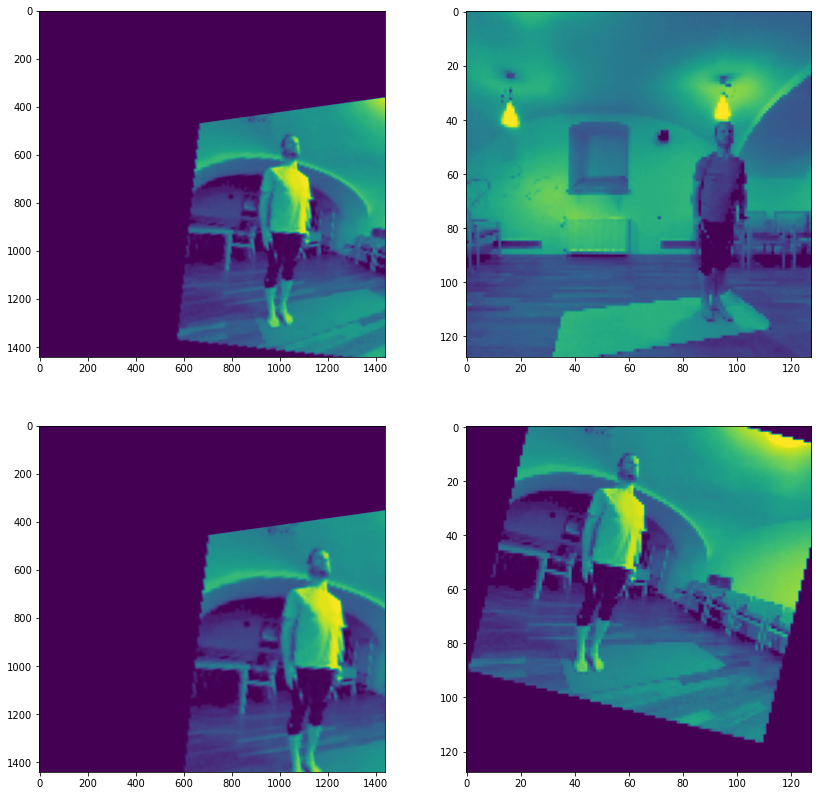

In [76]:
iteration = random.choice(iterations)
im, gt, paths = iteration["batch"]

src = im[0][1]
src = src.cpu().detach().numpy()
src = cv2.resize(src[0], (1440, 1440))

dst = im[0][0]
dst = dst.cpu().detach().numpy()
dst = cv2.resize(dst[0], (1440, 1440))

output = iteration['outputs'][0].cpu()
translationMat = np.mat([[output[2], 0., output[0]], [0., output[2], output[1]], [0., 0., 1.]] , dtype=np.float32)
rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), int(output[3]), 1)
outputTransform = np.matmul(np.vstack([rotationMat, [0,0,1]]),translationMat, dtype=np.float32)

GT = gt[0].cpu()
GTtranslationMat = np.mat([[GT[2], 0., GT[0]], [0., GT[2], GT[1]], [0., 0., 1.]] , dtype=np.float32)
GTrotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), int(GT[3]), 1)
GTTransform = np.matmul(np.vstack([GTrotationMat, [0,0,1]]), GTtranslationMat, dtype=np.float32)

np.set_printoptions(precision=3, suppress=True)
print(f"Ground Truth :\n {np.array(GT)}")
print(f"Transofrm    :\n {np.array(output)}")
print(f"loss: {iteration['loss']}")

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Ground Truth
warped = cv2.warpAffine(src, GTTransform[0:-1, : ], (1440, 1440))
axes[0][0].imshow(warped)

# Network Result
warped = cv2.warpAffine(src, outputTransform[0:-1, : ], (1440, 1440))

axes[1][0].imshow(warped)

# Network Imputs
axes[0][1].imshow(im[0][0].view(128,128))
axes[1][1].imshow(im[0][1].view(128,128))

